In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
keras = tf.keras

### Analytic Solution of Black-Scholes model

In [2]:
def BlackScholes(tau, S, K, sigma, alldata = None):
    d1=np.log(S/K)/sigma/np.sqrt(tau)+0.5*sigma*np.sqrt(tau)
    d2=d1-sigma*np.sqrt(tau)
    price=(S*norm.cdf(d1)-K*norm.cdf(d2))
    delta=norm.cdf(d1) 
    gamma=norm.pdf(d1)/(S*sigma*np.sqrt(tau))
    vega=S*norm.pdf(d1)*np.sqrt(tau)
    theta=-.5*S*norm.pdf(d1)*sigma/np.sqrt(tau)
    if alldata:
        data = {'npv':price,'delta':delta,'gamma':gamma,'vega':vega,'theta':theta}
        return data
    else:
        return price
    
    
N=100 # time disrectization    
S0=1 # initial value of the asset
T=1 # maturity
strike = 1.0
sigma=0.2 # volatility in Black Scholes    
BlackScholes(T, S0, strike, sigma)

0.07965567455405798

### Build neural networks at each trading time

In [3]:
def build_network(m, n , d, N):
# architecture is the same for all networks
    Networks = []
    trainable = True
    for j in range(N):
        inputs = keras.Input(shape=(m,))
        x = inputs
        for i in range(d):
            if i < d-1:
                nodes = n
                layer = keras.layers.Dense(nodes, activation='tanh',trainable=trainable,
                          kernel_initializer=keras.initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(j) + 'step' + str(i) + 'layer')
                x = layer(x)
            else:
                nodes = m
                layer = keras.layers.Dense(nodes, activation='linear', trainable=trainable,
                              kernel_initializer=keras.initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                              bias_initializer='random_normal',
                              name=str(j) + 'step' + str(i) + 'layer')
                outputs = layer(x)
                network = keras.Model(inputs = inputs, outputs = outputs)
                Networks.append(network)
    return Networks

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 32  # nodes in the first but last layers
Networks = build_network(m, n , d, N)
Network0 = keras.layers.Dense(m, use_bias=False)
print('neural network at time 0.36 is: ')
Networks[36].summary()

neural network at time 0.36 is: 
Model: "functional_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
36step0layer (Dense)         (None, 32)                64        
_________________________________________________________________
36step1layer (Dense)         (None, 32)                1056      
_________________________________________________________________
36step2layer (Dense)         (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


### Build the deep hedging dynamic 

In [4]:
price = keras.Input(shape=(N+1,m))   # S_{t}; t=0,..,N+1; (batch, N+1, m)
price_difference = price[:,1:,:] - price[:,:-1,:]  # dS_{t}; t=0,..,N; (batch, N, m)
hedge = tf.zeros_like(price[:,0,:])  # X_{0} = 0; (batch, m)
premium = Network0(tf.ones_like(price[:,0,:])) # premium; (batch, m)
for j in range(N):
    strategy = Networks[j](price[:,j,:])  # H_{t} = nn(S_{t}); (batch, m)
    hedge = hedge + strategy * price_difference[:,j,:]   # dX_{t} = H_{t}dS_{t}; (batch, m)
outputs = premium + hedge # premium + \int_{0}^{T}H_{t}dS_{t}; (batch, m)
model_hedge = keras.Model(inputs=price, outputs=outputs)

### Generate price paths of Black-Scholes model
$$
S_{t} = S_{0}e^{\sigma W_{t} - \frac{\sigma^{2}}{2}t}
$$

In [5]:
# time_grid = np.linspace(0,T,N+1)
# dt = T/N
# Ktrain = 10**5

# BM_path_helper = np.cumsum(np.random.normal(size = [Ktrain,N,m], loc=0, scale=np.sqrt(dt)),axis = 1) # generate and sum the increment of BM
# BM_path = np.concatenate([np.zeros([Ktrain,1,m]),BM_path_helper],axis = 1) # set initial position of BM be 0 
# price_path = S0 * np.exp(sigma * BM_path - 0.5 * sigma **2 * time_grid[None,:,None])  # from BM to geometric BM

# payoff_function = lambda x : 0.5*(np.abs(x-strike)+x-strike) # Call option payoff
# payoff = payoff_function(price_path[:,-1,:]) 

# plt.plot(price_path[:3,:,0].T)
# plt.grid()
# plt.show()

### Generate Heston paths


The price of the asset $S_t$ is determined by a stochastic process:

<center> $dS_{t}=\mu S_{t}\,dt+{\sqrt  {\nu_{t}}}S_{t}\,dW_{t}^{S}$ </center>

The instantaneous variance $\nu_t$ is a CIR process:

<center> $d\nu_{t}=\kappa (\theta -\nu_{t})\,dt+\xi {\sqrt  {\nu_{t}}}\,dW_{t}^{{\nu }}$ </center>


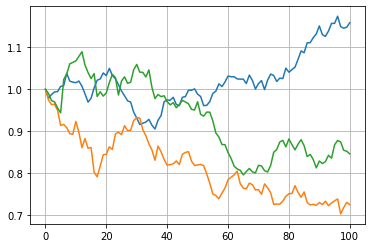

In [6]:
import utils

Ktrain = 10**5
## Parameters
corr = -0.3     # correlation between the two process
kappa = 0.9     # kappa: mean reversion rate
theta = 0.2     # theta: long-term volatility
xi = 0.2        # xi: volatility of volatility

## Initialization - could have other values
S0 = 1 * np.ones((Ktrain,m))
v0 = theta * np.ones((Ktrain,m))

price_path, vol_path = utils.stimulate_Heston(m,Ktrain,N,T,corr,kappa,theta,xi,S0,v0)

payoff_function = lambda x : 0.5*(np.abs(x-strike)+x-strike) # Call option payoff
payoff = payoff_function(price_path[:,-1,:]) 

plt.plot(price_path[:3,:,0].T)
plt.grid()
plt.show()

In [7]:
xtrain = price_path  # input be price_path
ytrain = payoff  # output be payoff
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # specify the optmizer 
model_hedge.compile(optimizer = optimizer,loss='mse') # specify the mean square loss 
model_hedge.fit(x=xtrain,y=ytrain, epochs=10,verbose=True,batch_size=1000) # train the model 
hedge_output = model_hedge.predict(xtrain) # compute the output (deep replicate payoff) with trained model 

Epoch 1/10
100/100 [==============================] - 3s 27ms/step - loss: 0.0126
Epoch 2/10
100/100 [==============================] - 3s 27ms/step - loss: 7.3754e-04
Epoch 3/10
100/100 [==============================] - 3s 26ms/step - loss: 6.0633e-04
Epoch 4/10
100/100 [==============================] - 3s 27ms/step - loss: 5.6296e-04
Epoch 5/10
100/100 [==============================] - 3s 26ms/step - loss: 5.1959e-04
Epoch 6/10
100/100 [==============================] - 2s 25ms/step - loss: 5.0302e-04
Epoch 7/10
100/100 [==============================] - 3s 25ms/step - loss: 4.8387e-04
Epoch 8/10
100/100 [==============================] - 3s 26ms/step - loss: 4.6542e-04
Epoch 9/10
100/100 [==============================] - 2s 25ms/step - loss: 4.7130e-04
Epoch 10/10
100/100 [==============================] - 2s 25ms/step - loss: 4.6287e-04


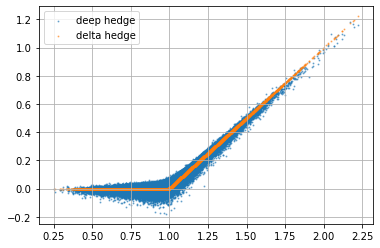

In [8]:
plt.scatter(price_path[:,-1,0], hedge_output[:,0], s = 1, alpha = 0.5, label = 'deep hedge')   # deep replicate payoff 
plt.scatter(price_path[:,-1,0], payoff[:,0], s = 1, alpha = 0.5, label = 'delta hedge')        # real payoff 
plt.legend()
plt.grid()

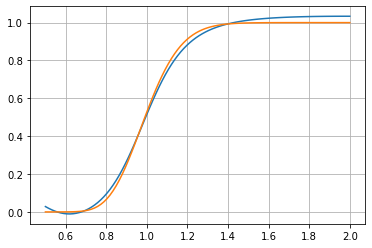

In [12]:
n = 50  # look at time 0.5
pr = tf.linspace(0.5,2,100)[:,None]  # tf.tensor of different price 
he = Networks[n](pr) # the stategy network at time 0.5 
plt.plot(pr[:,0],he[:,0], label = 'deep hedge') # plot the relation between price and deep strategy

tau = n/N # time 0.5
S = pr.numpy()[:,0] # np.array of different price
K = strike  
d1=np.log(S/K)/sigma/np.sqrt(tau)+0.5*sigma*np.sqrt(tau)
delta=norm.cdf(d1) 
plt.plot(S,delta, label = 'delta hedge') # plot the relation between price and delta strategy

#     plt.legend()
plt.grid()
plt.show()

In [16]:
print(f"deep hedge: {Network0(tf.ones([1,1])).numpy()[0,0]:{1}.{4}}")         # premium of deep hedge (truncted printing)
print(f"delta hedge: {BlackScholes(T, 1, strike, sigma):{1}.{4}}")           # premium of delta hedge (truncted printing)


deep hedge: 0.07982
delta hedge: 0.07966
